In [232]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [3]:
def readJSON(path):
    for l in gzip.open(path, 'r+'):
        d = eval(l)
        u = d['userID']
        try:
            g = d['gameID']
        except Exception as e:
            g = None
        yield u,g,d
    
def parseData(path):
    for l in gzip.open(path, 'r+'):
        yield eval(l)

In [20]:
cars = pd.read_csv('vehicles.csv')

In [14]:
temp = cars.drop(columns=['Unnamed: 0', 'url', 'region_url', 'VIN', 'image_url', 'lat','long','posting_date'])['type'].value_counts()
cars.drop(columns=['Unnamed: 0', 'url', 'region_url', 'VIN', 'image_url', 'lat','long','posting_date'])['type'].value_counts()/sum(temp)

sedan          0.267354
SUV            0.231224
pickup         0.125459
truck          0.103319
other          0.069933
coupe          0.055304
hatchback      0.047436
wagon          0.030315
van            0.027713
convertible    0.019868
mini-van       0.018129
bus            0.002075
offroad        0.001873
Name: type, dtype: float64

In [15]:
wack = cars.drop(columns=['Unnamed: 0', 'url', 'region_url', 'VIN', 'image_url', 'lat','long','posting_date']).dropna()['type'].value_counts()
wack/sum(wack)

sedan          0.294327
SUV            0.263000
truck          0.154327
pickup         0.074595
coupe          0.050940
hatchback      0.043999
van            0.042355
mini-van       0.026498
convertible    0.021383
wagon          0.019476
other          0.004521
offroad        0.003379
bus            0.001199
Name: type, dtype: float64

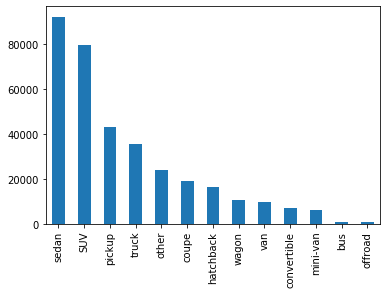

In [16]:
temp.plot(kind='bar')

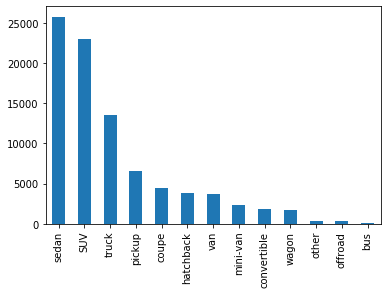

In [17]:
wack.plot(kind='bar')

In [22]:
temp2 = cars.drop(columns=['Unnamed: 0', 'url', 'region_url', 'VIN', 'image_url', 'lat','long','posting_date'])['manufacturer'].value_counts()
temp2/sum(temp2)

ford               0.181062
chevrolet          0.147677
toyota             0.087676
honda              0.058792
nissan             0.053760
jeep               0.048103
ram                0.040221
gmc                0.039244
dodge              0.038023
bmw                0.028073
hyundai            0.024944
mercedes-benz      0.024155
subaru             0.023887
volkswagen         0.023839
kia                0.020123
chrysler           0.017043
lexus              0.016180
cadillac           0.015325
buick              0.013657
mazda              0.013480
audi               0.012689
acura              0.009109
infiniti           0.008441
lincoln            0.007586
pontiac            0.006902
volvo              0.006514
mini               0.005296
mitsubishi         0.005230
porsche            0.004043
rover              0.003777
mercury            0.003739
saturn             0.003166
tesla              0.002425
jaguar             0.002409
fiat               0.002170
alfa-romeo         0

In [23]:
wack2 = cars.drop(columns=['Unnamed: 0', 'url', 'region_url', 'VIN', 'image_url', 'lat','long','posting_date']).dropna()['manufacturer'].value_counts()
wack2/sum(wack2)

ford               0.189285
chevrolet          0.152033
toyota             0.087735
honda              0.065336
nissan             0.055278
jeep               0.040015
gmc                0.039193
dodge              0.036510
ram                0.034580
hyundai            0.025459
subaru             0.024580
bmw                0.023975
volkswagen         0.022536
mercedes-benz      0.021817
kia                0.019625
chrysler           0.019088
cadillac           0.015926
lexus              0.014510
mazda              0.014111
buick              0.013323
audi               0.010823
acura              0.009282
pontiac            0.009236
lincoln            0.008619
volvo              0.007843
infiniti           0.006884
mitsubishi         0.006816
mercury            0.005491
mini               0.004783
saturn             0.004418
rover              0.002592
porsche            0.002569
jaguar             0.002409
fiat               0.001827
tesla              0.000662
alfa-romeo         0

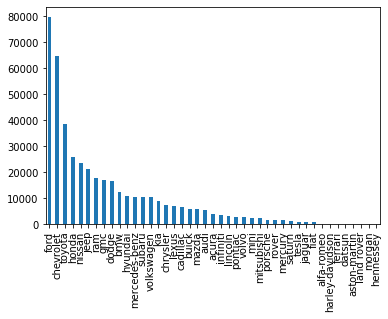

In [25]:
temp2.plot(kind='bar')

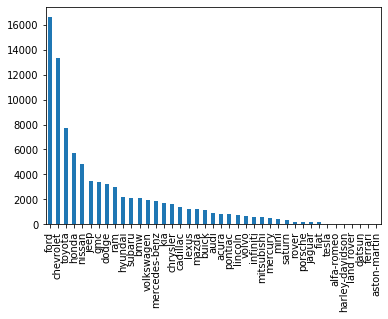

In [26]:
wack2.plot(kind='bar')

In [21]:
cars.drop(columns=['Unnamed: 0', 'url', 'region_url', 'VIN', 'image_url', 'lat','long','posting_date']).dropna()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state
3,7240103965,auburn,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,rwd,full-size,pickup,blue,1974 chev. truck (LONG BED) NEW starter front ...,al
4,7239983776,auburn,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,4wd,full-size,pickup,blue,2005 Ford F350 Lariat (Bullet Proofed). This t...,al
14,7237009212,auburn,4900,2003.0,ford,expedition,good,8 cylinders,gas,177000.0,clean,automatic,rwd,full-size,SUV,blue,"2003 Ford Expedition Eddie Baurer. 5.4L 2x4, S...",al
19,7235942858,auburn,47000,2020.0,jeep,gladiator,like new,6 cylinders,gas,10500.0,clean,automatic,4wd,full-size,pickup,grey,I'm putting up for sale my Jeep Gladiator. I j...,al
47,7231143951,auburn,6250,2010.0,ford,fusion sel,good,6 cylinders,gas,82000.0,clean,automatic,fwd,full-size,sedan,silver,"Driven 82,000 miles Automatic transmission Ext...",al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458204,7240975107,wausau,4495,2006.0,buick,lacrosse cx,good,6 cylinders,gas,121488.0,clean,automatic,fwd,mid-size,sedan,black,"2006 Buick Lacrosse, CX 3.8 V6, 1 owner, clean...",wi
458208,7240959076,wausau,14995,2014.0,cadillac,srx,excellent,6 cylinders,gas,83790.0,clean,automatic,4wd,mid-size,SUV,silver,2014 Cadillac SRX All Wheel Drive Luxury Colle...,wi
458209,7240954682,wausau,17895,2018.0,hyundai,tucson,excellent,4 cylinders,gas,31888.0,clean,automatic,4wd,mid-size,SUV,white,2018 Hyundai Tucson SE 2.0 I4 AWD. Carfax ver...,wi
458210,7240645700,wyoming,17900,2014.0,cadillac,cts coupe awd,excellent,6 cylinders,gas,53000.0,clean,automatic,4wd,mid-size,coupe,black,"53,000 miles. Cosmetically, in near mint condi...",wy


In [27]:
cars_naless = cars.drop(columns=['Unnamed: 0', 'url', 'region_url', 'VIN', 'image_url', 'lat','long','posting_date']).dropna()

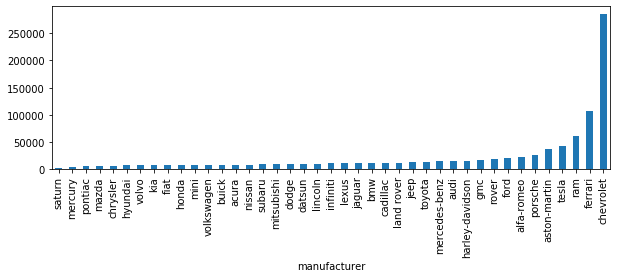

In [31]:
plt.figure(figsize = (10,3))
cars_naless.groupby('manufacturer').mean()['price'].sort_values().plot(kind='bar');

In [37]:
cars_0_naless = cars_naless[cars_naless['price'] != 0].reset_index(drop=True)

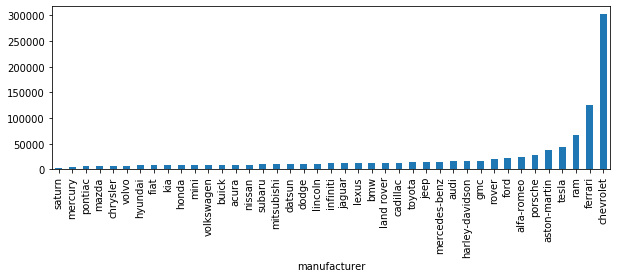

In [39]:
plt.figure(figsize = (10,3))
cars_0_naless.groupby('manufacturer').mean()['price'].sort_values().plot(kind='bar');

In [56]:
cars_0_naless[cars_0_naless['manufacturer'] == 'chevrolet'].sort_values('price',ascending=False)['description'].iloc[2]

'"Say Hello to my Little Friend" CUSTOM, CHROME AND CRAZY C10! 1971 CHEVY C10  Location: Andover, NJ 07821 Year: 1971 Make: Chevrolet Model: C10 Vin# 1CE141B635219 Miles: 20 Brand New Engine: JEGS- Chevy 572hp - 30401 Kit, E-Z Electronic Fuel Injection 2.0, Wildwood Master Cylinder, Black Ceramic Coated Headers, Hydro-Dipped Valve Covers, Be-Cool Radiator, SureFit Air Condition System w/ Chrome Lines, Chromed Water Pump Trans: 4L80E-11" Torque Converter 3000 RPM Stall Speed, HDM Electronics Computer Shift, JEGS-18" Stainless Steel Double "D" Shaft Exhaust: PYPES - 3" Universal Builders Exhaust w/JEGS - Stainless Steel Mufflers & Tips Brakes: Stainless Steel System & Lines Wheels: Foose Impala - 20x12 & 19x10 w/6" Backs Spacers Tires: Michelin Super Sport -315x35x20 & 275x35x19 Competition Engineering Over-sized Wheel Tubs Custom Door Popper Entrance System Custom Fuel Tank & Stainless Steel Gas Filler Screen Cap Pioneer Stereo System & Kicker Components Custom Power Rear Window w/ Scar

In [70]:
cars_0_naless[cars_0_naless['price'] < 101].sort_values('price',ascending=False)#['description'].iloc[3]#[:20]

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state
988,7233483495,mobile,100,2015.0,lexus,es 300h,like new,6 cylinders,hybrid,52115.0,clean,automatic,fwd,full-size,sedan,white,WOW TOP OF THE LINE LEXUS WITH ONLY 52000 MI...,al
1021,7231332293,mobile,100,2015.0,lexus,es 300h,like new,6 cylinders,hybrid,52115.0,clean,automatic,fwd,full-size,sedan,white,WOW TOP OF THE LINE LEXUS WITH ONLY 52000 MI...,al
61966,7240343980,lehigh valley,100,2018.0,nissan,versa,excellent,4 cylinders,gas,40000.0,clean,automatic,fwd,mid-size,sedan,white,ALL CARS $100-500 DUE AT SIGNING!!!! NO CREDI...,pa
32670,7237022438,frederick,100,1987.0,ford,f-150,salvage,6 cylinders,gas,265000.0,missing,manual,rwd,full-size,truck,red,This is a non-running 87 f150. NO Title Need t...,md
61975,7239925223,lehigh valley,100,2018.0,nissan,versa,excellent,4 cylinders,gas,40000.0,clean,automatic,fwd,mid-size,sedan,grey,ALL CARS $100-500 DUE AT SIGNING!!!! NO CREDI...,pa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16792,7231974894,ocala,1,2017.0,subaru,wrx,excellent,10 cylinders,gas,47289.0,clean,other,4wd,compact,sedan,red,CREDIT AMNESTY! SE HABLA ESPANOL !!OPEN SUNDA...,fl
16791,7231975026,ocala,1,2016.0,jeep,wrangler,excellent,10 cylinders,gas,34916.0,clean,other,4wd,full-size,SUV,black,CREDIT AMNESTY! SE HABLA ESPANOL !!OPEN SUNDA...,fl
16780,7232989906,ocala,1,2005.0,chevrolet,silverado 3500,excellent,8 cylinders,diesel,140902.0,clean,automatic,rwd,full-size,pickup,white,"2005 Chevy Silverado 3500 LT - Dually, leather...",fl
16744,7234836185,ocala,1,2005.0,jeep,liberty 4x4 limited,good,6 cylinders,gas,200000.0,clean,automatic,4wd,mid-size,SUV,blue,***MUST SELL 2005 JEEP LIBERTY 4x4 LIMITED $2...,fl


In [88]:
len(cars_0_naless[(cars_0_naless['description'].str.isupper()) & (cars_0_naless['price'] < 10000)]['description'].unique())#.iloc[3]#[:20]

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state
61,7238213055,birmingham,9900,2014.0,toyota,camry se 4dr sedan,excellent,4 cylinders,gas,105695.0,clean,automatic,fwd,mid-size,sedan,red,PLEASE REFER TO THE PICTURE OF THE ORIGINAL WI...,al
337,7230203831,birmingham,1500,1997.0,mazda,626,good,6 cylinders,gas,193000.0,clean,automatic,fwd,mid-size,sedan,green,NEEDS FUEL PUMP,al
410,7225573395,birmingham,3500,2006.0,honda,accord,good,6 cylinders,gas,275000.0,clean,automatic,fwd,mid-size,sedan,white,"CRANKS, RUNS, DRIVES.",al
415,7224999868,birmingham,9950,2013.0,volkswagen,passat tdi se,excellent,4 cylinders,gas,60120.0,clean,automatic,fwd,full-size,sedan,black,2013 VOLSWAGEN PASSAT TDI SE TURBO DIESEL. 601...,al
727,7231370693,huntsville / decatur,5500,2010.0,toyota,corolla,good,4 cylinders,gas,90321.0,rebuilt,automatic,fwd,compact,sedan,custom,4DOOR,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84043,7241009526,houston,2250,1994.0,jeep,grand cherokee laredo,good,8 cylinders,gas,188000.0,clean,automatic,4wd,mid-size,SUV,green,1994 JEEP GRAND CHEROKEE LAREDO ***** 4 BY 4 *...,tx
84044,7241009069,houston,1650,2005.0,chevrolet,equinox,good,6 cylinders,gas,138000.0,rebuilt,automatic,fwd,mid-size,SUV,green,2005 CHEVROLET EQUINOX ****** FOREST GREEN WIT...,tx
84196,7241005423,milwaukee,6500,2011.0,gmc,terrain slt,good,4 cylinders,gas,130000.0,clean,automatic,fwd,mid-size,SUV,grey,"130K MI. ALL POWER, LEATHER, AND SUNROOF ! RUN...",wi
84197,7241004327,milwaukee,3300,2006.0,mazda,6,good,6 cylinders,gas,55900.0,clean,automatic,fwd,mid-size,sedan,silver,"56K MI. ALL POWER , LEATHER INTERIOR , 6CYL. A...",wi


In [96]:
cars_0_naless.drop_duplicates('description',keep=False)
jasraj = cars_0_naless['description'].value_counts()
len(jasraj[jasraj>1])
set(jasraj[jasraj>1].values)

{2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 23,
 25,
 28,
 29,
 30,
 33,
 40,
 41,
 71,
 106,
 143,
 189}

In [110]:
cleaned_cars = cars_0_naless[(cars_0_naless['price'] < 300000) & (cars_0_naless['price'] > 100)]#.sort_values('price',ascending=False)#[:20]

In [214]:
cleaned_cars = cleaned_cars[cleaned_cars['odometer'] < 500000]

In [196]:
cleaned_cars['cylinders'].unique()
cleaned_cars[cleaned_cars['cylinders'] == 'other']

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state
457,7235979040,dothan,39900,2020.0,tesla,mod 3,like new,other,electric,3461.0,clean,automatic,fwd,full-size,sedan,black,"ALWAYS GARAGED, NEVER IN RAIN, NON-SMOKER MODE...",al
467,7235300099,dothan,11000,2001.0,ford,f350 super duty,good,other,diesel,258000.0,clean,automatic,rwd,full-size,truck,white,2001 f350 long wheel base. Very clean truck ha...,al
562,7239654331,huntsville / decatur,17900,2017.0,bmw,i3 range extender,excellent,other,electric,45000.0,clean,automatic,rwd,sub-compact,hatchback,white,"2017 BMW I3 94ah with Range Extender, 45,000 m...",al
1132,7224997527,mobile,4950,2008.0,toyota,prius,good,other,gas,178532.0,clean,automatic,fwd,compact,sedan,brown,MPG:\t48 city / 45 hwy Style:\tStandard 4dr Ha...,al
1402,7238488489,anchorage / mat-su,5000,2007.0,mazda,rx8,like new,other,gas,140000.0,clean,manual,rwd,sub-compact,other,silver,Selling Mazda RX8 very good shape has 140k ok ...,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83262,7240830038,minneapolis / st paul,14750,2016.0,bmw,i3 range extender hatchback,good,other,electric,74800.0,clean,automatic,rwd,compact,hatchback,black,Up for sale is my 2016 BMW I3 Range Extender. ...,mn
83496,7240843927,albuquerque,6900,2010.0,mazda,rx8,good,other,gas,53000.0,salvage,manual,rwd,compact,coupe,red,2010 MAZDA RX8 SPOT ENGINE 1.3L ROTARY WHITH 5...,nm
83899,7240997677,pittsburgh,19995,2011.0,ford,f350 4x4,good,other,gas,72069.0,clean,automatic,4wd,full-size,truck,red,2011 Ford F350 4x4 6.2 gas. 8ft Western Plow. ...,pa
83921,7241009127,charleston,4600,2012.0,nissan,leaf,excellent,other,electric,58650.0,clean,automatic,fwd,mid-size,hatchback,white,"show contact info All electric, never pay for...",sc


In [222]:
cleaned_cars['cylinders'].apply(lambda x: x.split()[0]).unique()

array(['4', '8', '6', '10', '3', 'other', '5', '12'], dtype=object)

In [124]:
semp = cleaned_cars['model'].value_counts()
semp[semp>100]

f-150               1540
silverado 1500      1238
1500                 917
camry                746
accord               722
                    ... 
srx                  102
super duty f-250     102
cooper               101
avalanche            101
f-350 super duty     101
Name: model, Length: 157, dtype: int64

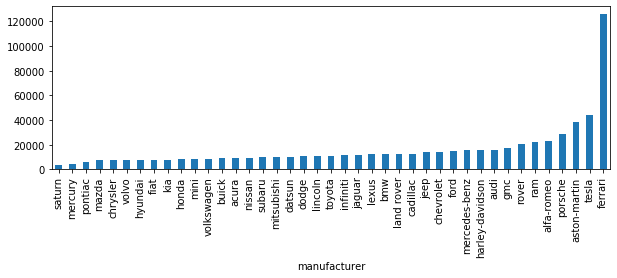

In [111]:
plt.figure(figsize = (10,3))
cleaned_cars.groupby('manufacturer').mean()['price'].sort_values().plot(kind='bar');

In [221]:
year = cleaned_cars['year'].tolist()
odom = (cleaned_cars['odometer']/max(cleaned_cars['odometer'])).tolist()

In [224]:
manu = cleaned_cars['manufacturer'].unique().tolist()
cond = cleaned_cars['condition'].unique().tolist()
cycl = cleaned_cars['cylinders'].unique().tolist()
fuel = cleaned_cars['fuel'].unique().tolist()
tit = cleaned_cars['title_status'].unique().tolist()
tran = cleaned_cars['transmission'].unique().tolist()
drive = cleaned_cars['drive'].unique().tolist()
size = cleaned_cars['size'].unique().tolist()
typ = cleaned_cars['type'].unique().tolist()
paint = cleaned_cars['paint_color'].unique().tolist()
state = cleaned_cars['state'].unique().tolist()

In [225]:
manu_One = np.zeros((len(cleaned_cars),len(manu)))
cond_One = np.zeros((len(cleaned_cars),len(cond)))
cycl_One = np.zeros((len(cleaned_cars),len(cycl)))
fuel_One = np.zeros((len(cleaned_cars),len(fuel)))
tit_One = np.zeros((len(cleaned_cars),len(tit)))
tran_One = np.zeros((len(cleaned_cars),len(tran)))
drive_One = np.zeros((len(cleaned_cars),len(drive)))
size_One = np.zeros((len(cleaned_cars),len(size)))
typ_One = np.zeros((len(cleaned_cars),len(typ)))
paint_One = np.zeros((len(cleaned_cars),len(paint)))
state_One = np.zeros((len(cleaned_cars),len(state)))

In [227]:
for x in range(len(cleaned_cars)):
    manu_One[x][manu.index(cleaned_cars['manufacturer'].iloc[x])] = 1
    cond_One[x][cond.index(cleaned_cars['condition'].iloc[x])] = 1
    cycl_One[x][cycl.index(cleaned_cars['cylinders'].iloc[x])] = 1
    fuel_One[x][fuel.index(cleaned_cars['fuel'].iloc[x])] = 1
    tit_One[x][tit.index(cleaned_cars['title_status'].iloc[x])] = 1
    tran_One[x][tran.index(cleaned_cars['transmission'].iloc[x])] = 1
    drive_One[x][drive.index(cleaned_cars['drive'].iloc[x])] = 1
    size_One[x][size.index(cleaned_cars['size'].iloc[x])] = 1
    typ_One[x][typ.index(cleaned_cars['type'].iloc[x])] = 1
    paint_One[x][paint.index(cleaned_cars['paint_color'].iloc[x])] = 1
    state_One[x][state.index(cleaned_cars['state'].iloc[x])] = 1

In [228]:
categoryCounts = {}
for x in cleaned_cars['model']:
    if x not in categoryCounts.keys():
        categoryCounts[x] = 0
    categoryCounts[x] += 1
categories = [c for c in categoryCounts if categoryCounts[c] > 100]
catID = dict(zip(list(categories),range(len(categories))))

In [229]:
mod_One = np.zeros((len(cleaned_cars),len(catID.keys())))
for x in range(len(cleaned_cars)):
    if cleaned_cars['model'].iloc[x] in catID.keys():
        mod_One[x][catID[cleaned_cars['model'].iloc[x]]] = 1

In [233]:
x_train, x_test, y_train, y_test = train_test_split(cleaned_cars.drop(columns=['price']), cleaned_cars['price'], test_size=0.3, random_state=42)
avg_price = y_train.mean()

In [234]:
train_pred = [avg_price]*len(x_train)
test_pred = [avg_price]*len(x_test)

In [239]:
def RMSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return np.sqrt(sum(differences) / len(differences))

In [240]:
RMSE(train_pred,y_train)

11244.698183156628

In [241]:
RMSE(test_pred,y_test)

11398.689237306486